/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/root/CoTFaithChecker


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_13705/2729165304.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` 

Probe → layer 14, position idx 0
Running on CUDA  – dtype torch.bfloat16


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



3 random examples:
question                                                | GT | α=0 | α=0.5 | α=1 | α=5 | α=10
---------------------------------------------------------------------------------------------
about NYT articles:

Was "Nazi War Crimes Suspect, 98,  | YES | YES | YES | YES | YES | NO
about NYT articles:

Was "Iraqi Camp for Iranians Faces | NO | YES | YES | YES | YES | YES
about US cities:

Is White Horse, NJ less populous than | YES | YES | YES | YES | YES | NO

summary over all prompts:
     α |  acc | OTHER
-----------------------
     0 |  107/200 |     0
   0.5 |  106/200 |     0
     1 |  106/200 |     0
     5 |  105/200 |     0
    10 |   97/200 |     0


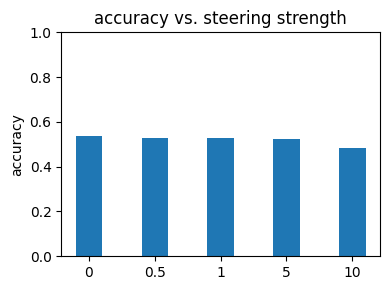


── GT vs before(α=0) vs after(α=0.5 )────────────────────────
GT   | before | after 
------------------------
NO   | YES    | YES   
YES  | YES    | YES   
NO   | YES    | YES   
YES  | YES    | YES   
NO   | YES    | YES   
YES  | YES    | YES   
YES  | YES    | YES   
NO   | YES    | YES   
YES  | YES    | YES   
NO   | NO     | NO    
YES  | YES    | YES   
YES  | YES    | YES   
YES  | YES    | YES   
YES  | YES    | YES   
NO   | YES    | YES   
NO   | YES    | YES   
YES  | YES    | YES   
NO   | YES    | YES   
YES  | YES    | YES   
NO   | YES    | YES   
NO   | YES    | YES   
YES  | YES    | YES   
YES  | YES    | YES   
YES  | YES    | YES   
YES  | YES    | YES   
YES  | NO     | NO    
NO   | NO     | NO    
NO   | YES    | YES   
YES  | YES    | YES   
NO   | YES    | YES   
NO   | YES    | YES   
NO   | YES    | YES   
YES  | YES    | YES   
NO   | YES    | YES   
YES  | YES    | YES   
YES  | NO     | NO    
YES  | YES    | YES   
YES  | YES    | YES   
NO   | YES    |

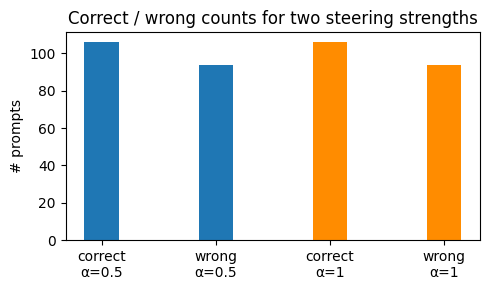

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


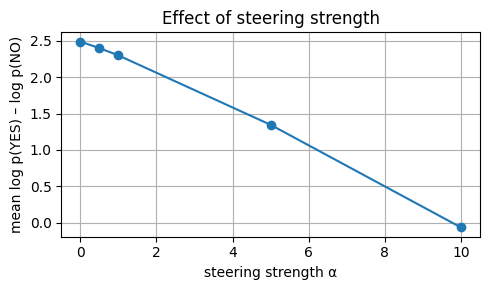

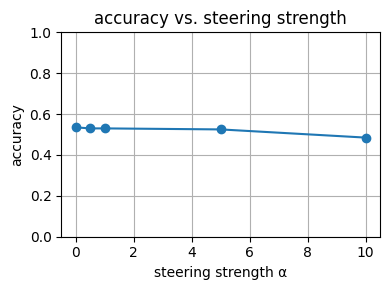

In [1]:
%cd ../..
%pwd
from pathlib import Path
MODEL_NAME      = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
PROBE_PATH      = Path("j_probing/probe/probe_weights.pt")

PROBE_LAYER     = 14      # transformer layer index (0-based)
TARGET_POSITION = 0       # 0 assistant, 1 think, 2 hint

ALPHAS          = [0, 0.5, 1, 5, 10]
N_QUESTIONS     = 200

DATA_ROOT       = Path("data/chainscope/questions_json/linked")
DATASETS        = ["gt_NO_1", "gt_YES_1", "lt_NO_1", "lt_YES_1"]

import random, json, torch, re
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import LogitsProcessor

class YesNoProcessor(LogitsProcessor):
    def __init__(self, yes_id, no_id):
        super().__init__()
        self.yes_id, self.no_id = yes_id, no_id

    def __call__(self, input_ids, scores):
        mask = torch.full_like(scores, -float("inf"))
        mask[:, self.yes_id] = mask[:, self.no_id] = 0
        return scores + mask
    
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = torch.bfloat16 if device == "cuda" else torch.float32

state = torch.load(PROBE_PATH, map_location="cpu")
steer_vec = state["w"].squeeze().float()
steer_vec = (steer_vec / steer_vec.norm()).to(dtype).to(device)

tok = AutoTokenizer.from_pretrained(MODEL_NAME)
tok.padding_side = "left"
tok.pad_token = tok.pad_token or tok.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=dtype,
    device_map="auto",
    output_hidden_states=False,
).eval()

layer_dim = model.model.layers[PROBE_LAYER].mlp.up_proj.weight.shape[1]
assert layer_dim == steer_vec.numel(), "probe / model d_model mismatch"

# YES / NO token-IDs (take last sub-token so they differ)
YES_ID = tok.encode(" YES", add_special_tokens=False)[-1]
NO_ID  = tok.encode(" NO",  add_special_tokens=False)[-1]

print(f"Probe → layer {PROBE_LAYER}, position idx {TARGET_POSITION}")
print(f"Running on {device.upper()}  – dtype {dtype}")

questions = []          # list[(prompt, ground_truth)]
for folder in DATASETS:
    for fp in (DATA_ROOT / folder).glob("*.json"):
        j = json.load(open(fp))
        gt = j["params"]["answer"]        # "YES" | "NO"
        for q in j["questions"]:
            questions.append((q["q_str"], gt))

random.shuffle(questions)
questions = questions[:N_QUESTIONS]
prompts = [p for p, _ in questions]
gt      = [g for _, g in questions]

def make_hook(alpha: float):
    delta = alpha * steer_vec
    rel_idx = -1 - TARGET_POSITION                # index from right
    def _hook(_m, _inp, out):
        t = out[0] if isinstance(out, tuple) else out
        t[:, rel_idx, :] += delta
    return _hook

@torch.inference_mode()
def run_alpha(prompts, alpha: float):
    h = model.model.layers[PROBE_LAYER].register_forward_hook(make_hook(alpha))
    enc = tok(prompts, return_tensors="pt", padding=True).to(device)
    out = model.generate(
        **enc,
        max_new_tokens=1,
        do_sample=False,
        logits_processor=[YesNoProcessor(YES_ID, NO_ID)],
        return_dict_in_generate=True, output_scores=True
    )
    h.remove()

    next_ids = out.scores[0].argmax(dim=-1).cpu().tolist()
    return ["YES" if tid == YES_ID else "NO" for tid in next_ids]

results = {α: run_alpha(prompts, α) for α in ALPHAS}

# ─────────────────── print three example rows ──────────────────────
ex_idx = random.sample(range(N_QUESTIONS), 3)
hdr = f"{'question':<55} | GT | " + " | ".join([f"α={a}" for a in ALPHAS])
print("\n3 random examples:")
print(hdr)
print("-"*len(hdr))
for i in ex_idx:
    row = f"{prompts[i][:55]:<55} | {gt[i]} | " + " | ".join(results[a][i] for a in ALPHAS)
    print(row)

def summary(alpha):
    pred = results[alpha]
    acc  = sum(p == t for p, t in zip(pred, gt))
    oth  = pred.count("OTHER")
    return acc, oth

print("\nsummary over all prompts:")
print(f"{'α':>6} | {'acc':>4} | {'OTHER':>5}")
print("-"*23)
for a in ALPHAS:
    acc, oth = summary(a)
    print(f"{a:>6} | {acc:>4}/{N_QUESTIONS} | {oth:>5}")

plt.figure(figsize=(4,3))
plt.bar([str(a) for a in ALPHAS], [summary(a)[0]/N_QUESTIONS for a in ALPHAS], width=0.4)
plt.ylim(0,1)
plt.ylabel("accuracy")
plt.title("accuracy vs. steering strength")
plt.tight_layout()
plt.show()

first_non_zero = ALPHAS[1]
print("\n── GT vs before(α=0) vs after(α={} )────────────────────────".format(first_non_zero))
print(f"{'GT':<4} | {'before':<6} | {'after':<6}")
print("-"*24)
for g, b, a in zip(gt, results[0], results[first_non_zero]):
    if b in ("YES","NO") and a in ("YES","NO"):
        print(f"{g:<4} | {b:<6} | {a:<6}")

alpha_A, alpha_B = ALPHAS[1], ALPHAS[2]
def corr_wrong(alpha):
    pred = results[alpha]
    corr = sum(p == t for p, t in zip(pred, gt))
    wrong = len(pred) - corr
    return corr, wrong

corr_A, wrong_A = corr_wrong(alpha_A)
corr_B, wrong_B = corr_wrong(alpha_B)

print("\ncorrect / wrong counts:")
print(f"        |  α={alpha_A:<4} (blue) |  α={alpha_B:<4} (orange)")
print("correct | {:>6}          | {:>6}".format(corr_A, corr_B))
print("wrong   | {:>6}          | {:>6}".format(wrong_A, wrong_B))

vals   = [corr_A, wrong_A, corr_B, wrong_B]
labels = [f'correct\nα={alpha_A}',
          f'wrong\nα={alpha_A}',
          f'correct\nα={alpha_B}',
          f'wrong\nα={alpha_B}']
colors = ['tab:blue', 'tab:blue', 'darkorange', 'darkorange']

plt.figure(figsize=(5,3))
plt.bar(range(4), vals, color=colors, width=0.3)
plt.xticks(range(4), labels)
plt.ylabel('# prompts')
plt.title('Correct / wrong counts for two steering strengths')
plt.tight_layout()
plt.show()

@torch.inference_mode()
def mean_logp_diff(alpha: float) -> float:
    """Mean[ log p(YES) − log p(NO) ] over the current prompt set."""
    h = model.model.layers[PROBE_LAYER].register_forward_hook(make_hook(alpha))
    enc = tok(prompts, return_tensors="pt", padding=True).to(device)
    out = model.generate(
        **enc,
        max_new_tokens=1,
        do_sample=False,
        return_dict_in_generate=True,
        output_scores=True
    )
    h.remove()

    logits = out.scores[0]                       # (batch, vocab)
    logp   = torch.log_softmax(logits, dim=-1)
    diff   = (logp[:, YES_ID] - logp[:, NO_ID]).cpu().numpy()
    return diff.mean()

mean_diffs = [mean_logp_diff(a) for a in ALPHAS]

plt.figure(figsize=(5,3))
plt.plot(ALPHAS, mean_diffs, marker='o')
plt.xlabel('steering strength α')
plt.ylabel('mean log p(YES) – log p(NO)')
plt.title('Effect of steering strength')
plt.grid(True)
plt.tight_layout()
plt.show()

acc_values = [summary(a)[0] / N_QUESTIONS for a in ALPHAS]

plt.figure(figsize=(4,3))
plt.plot(ALPHAS, acc_values, marker='o')
plt.ylim(0,1)
plt.xlabel('steering strength α')
plt.ylabel('accuracy')
plt.title('accuracy vs. steering strength')
plt.grid(True)
plt.tight_layout()
plt.show()